In [1]:
!pip install Keras-Preprocessing

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from tqdm import tqdm
import os
import opensmile
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from IPython.lib.display import Audio


In [3]:
audio_files_path ='IEMOCAP_full_release/Session1/sentences/wav/Ses01F_impro01/'
labels = 'IEMOCAP_full_release/Session1/dialog/EmoEvaluation/Categorical/Ses01F_impro01_e2_cat.txt'

list_of_labels=[]
with open(labels, 'r') as file:
    for line in file:
        parts = line.split(':')
        label = parts[1].split(';')[0]
        list_of_labels.append([parts[0],label])

def find_label_for_emotion(array,file):
    for sublist in array:
        sublist[0]=sublist[0].strip()
        file=file.strip()
        if sublist[0] in file:
            return sublist[1]
    return None


In [4]:
ses_one_audio_dir='./IEMOCAP_full_release/Session1/sentences/wav/'
ses_one_dir_labels_files='./IEMOCAP_full_release/Session1/dialog/EmoEvaluation/'


ses_two_audio_dir='./IEMOCAP_full_release/Session2/sentences/wav/'
ses_two_dir_labels_files='./IEMOCAP_full_release/Session2/dialog/EmoEvaluation/'



ses_three_audio_dir='./IEMOCAP_full_release/Session3/sentences/wav/'
ses_three_dir_labels_files='./IEMOCAP_full_release/Session3/dialog/EmoEvaluation/'



ses_four_audio_dir='./IEMOCAP_full_release/Session4/sentences/wav/'
ses_four_dir_labels_files='./IEMOCAP_full_release/Session4/dialog/EmoEvaluation/'



ses_five_audio_dir='./IEMOCAP_full_release/Session5/sentences/wav/'
ses_five_dir_labels_files='./IEMOCAP_full_release/Session5/dialog/EmoEvaluation/'



audio_paths=[ses_one_audio_dir,ses_two_audio_dir,ses_three_audio_dir,ses_four_audio_dir,ses_five_audio_dir]
labels_paths=[ses_one_dir_labels_files,ses_two_dir_labels_files,ses_three_dir_labels_files,ses_four_dir_labels_files,ses_five_dir_labels_files]


list_of_labels=[]
list_of_waves_with_label=[]



labels=['sad','neu','hap','ang']


for path in labels_paths: 
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if file.endswith('.txt'):
            with open(file_path, 'r') as file:
                for line in file:
                    for line in file:
                        match = re.match(r'\[\d+\.\d+ - \d+\.\d+\]\s(\S+)\s(\S+)\s\[\d+\.\d+, \d+\.\d+, \d+\.\d+\]', line)
                        if match:
                            session_name = match.group(1)
                            emotion = match.group(2)
                            if emotion in labels:
                                list_of_labels.append([session_name,emotion])

def find_label_for_emotion(array,file):
    for sublist in array:
        sublist[0]=sublist[0].strip()
        file=file.strip()
        if sublist[0] in file:
            return sublist[1]
    return None



for path in audio_paths: 
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
                for file in os.listdir(folder_path):
                    if file.endswith('.wav'):
                        full_path = os.path.join(folder_path, file)  
                        label=find_label_for_emotion(list_of_labels,file)
                        if label!=None:
                            list_of_waves_with_label.append([full_path,label])
                                 

print('data set size = ',len(list_of_waves_with_label))


counter_angry=0
counter_neu=0
counter_hap=0
counter_sad=0
for i in list_of_waves_with_label:
    if i[1] =='ang':
        counter_angry+=1
    if i[1] =='neu':
        counter_neu+=1
    if i[1] =='hap':
        counter_hap+=1
    if i[1] =='sad':
        counter_sad+=1
print('angry ',counter_angry)
print('neu ',counter_neu)
print('sad ',counter_sad)
print('hap ',counter_hap)


data set size =  4490
angry  1103
neu  1708
sad  1084
hap  595


In [5]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016, # 6373 features
    # feature_set=opensmile.FeatureSet.eGeMAPSv02, # 88 features
    feature_level=opensmile.FeatureLevel.Functionals,
)
# Function to extract MFCC features from audio files
def extract_features(file_path, mfcc=True, chroma=True, mel=True):
    with open(file_path, 'rb') as f:
        audio, sr = librosa.load(file_path, sr=None)
    features = []
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
        features.append(mfccs)
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
        features.append(chroma)
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
        features.append(mel)
    return np.concatenate(features)


In [6]:
list_of_waves_with_label_array=np.array(list_of_waves_with_label)
# Read the CSV file with the training data
df = pd.read_csv('./iemocapTrans.csv')

texts_train = df["to_translate"].to_list()
path_train = df["titre"].to_list()

features_df_train = pd.DataFrame()
y = []
texts = []
file_names=[]
if not os.path.exists("features_df.csv"):
    for x in tqdm(list_of_waves_with_label_array):
        wav_file = x[0].split("/")[-1]
        wav_file_without = wav_file.replace(".wav", "")
        if wav_file_without not in path_train:
            continue
        else:
            features = pd.DataFrame(extract_features(x[0]))
            smile_features = smile.process_file(x[0])
            smile_features.reset_index(drop=True, inplace=True)
            features = pd.concat([features.T, smile_features], ignore_index=True, axis=1)
            label = x[1]
            y.append(label)
            texts.append(texts_train[path_train.index(wav_file_without)])
            # concatenate features and labels to the dataframe
            features_df_train = pd.concat([features_df_train, features], ignore_index=True)
            file_names.append(wav_file)
    features_df_train['label'] = y
    features_df_train['text'] = texts
    features_df_train.to_csv("features_df.csv", index=False)
    labels = features_df_train['label']
    features_df_train.drop('label', axis=1, inplace=True)
else:
    # Load features_df_val from CSV file
    features_df_train = pd.read_csv("features_df.csv")
    labels = features_df_train['label']
    features_df_train.drop('label', axis=1, inplace=True)

100%|██████████| 4490/4490 [08:02<00:00,  9.31it/s]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(features_df_train, labels, test_size=0.2, random_state=42)
texts_train = X_train['text'].to_list()
texts_test = X_test['text'].to_list()
X_train.drop('text', axis=1, inplace=True)
X_test.drop('text', axis=1, inplace=True)

In [8]:
def preprocess_dataset(df_train, df_test):

    standard_scaler = preprocessing.StandardScaler()
    df_train_scaled = standard_scaler.fit_transform(df_train)
    df_test_scaled = standard_scaler.transform(df_test)

    return df_train_scaled, df_test_scaled

In [9]:
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

(3592, 6553) (898, 6553)


In [10]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [11]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
max_length_train = max([len(seq) for seq in sequences_train])
padded_sequences = pad_sequences(sequences_train, maxlen=max_length_train)

sequences_test = tokenizer.texts_to_sequences(texts_test)
max_length_test = max([len(seq) for seq in sequences_test])
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_length_test)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, text):
        self.data = data
        self.labels = labels
        self.text = text
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.text[idx]

def intialise_loaders(X_train, y_train, X_test, y_test, batch_size):
    train_data = CustomDataset(X_train, y_train, padded_sequences)
    test_data = CustomDataset(X_test, y_test, padded_sequences_test)
    train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size, shuffle=True)
    return train_dataloader, test_dataloader

optimal_bs = 256
train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, optimal_bs)

In [13]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
        elif score > self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model to {self.path}')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [14]:
# Define the MLP model
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        layers = []
        parameters = [no_features] + no_hidden
        for i in range(len(parameters) - 1):
            layers.append(nn.Linear(parameters[i], parameters[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        
        self.mlp_stack = nn.Sequential(*layers)
        self.fc = nn.Linear(parameters[-1], no_labels)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.mlp_stack(x)
        u = self.fc(x1)
        y = self.softmax(u)
        return y
    
# Define the CNN model for NLP processing
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])   
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = x.unsqueeze(1)  
        embedded = self.embedding(x)  
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]  
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]  
        cat = self.dropout(torch.cat(pooled, dim=1))  
        output = self.fc(cat)  
        return output
    
# Define the fusion layer
class FusionLayer(nn.Module):
    def __init__(self, audio_input_size, text_input_size, output_size, audio_weight=3.0):
        super(FusionLayer, self).__init__()
        self.combine = nn.Linear(audio_input_size + text_input_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, audio_features, text_features):
        combined_features = torch.cat((audio_features, text_features), dim=1)
        u = self.combine(combined_features)
        y = self.softmax(u)
        return y

# Define hyperparameters
input_size = X_train.shape[1]   
no_hidden = [256,256]
hidden_size = 512
num_classes = len(np.unique(y_train))
num_epochs = 100
batch_size = 32
learning_rate = 0.001
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
num_filters = 100
filter_sizes = [3, 4, 5]
dropout = 0.5

# Define the models
cnn_model = CNN(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout)
mlp_model = MLP(input_size, no_hidden, num_classes)
fusion_layer = FusionLayer(audio_input_size=num_classes, text_input_size=num_classes, output_size=num_classes)


# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(list(cnn_model.parameters()) + list(mlp_model.parameters()) + list(fusion_layer.parameters()), lr=learning_rate)
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=learning_rate)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)
fusion_optimizer = optim.Adam(fusion_layer.parameters(), lr=learning_rate)



In [15]:
# num_epochs = 100
# batch_size = 32
# early_stopping = EarlyStopping(patience=3, delta=0.1, verbose=True)

# training_losses = []
# training_accuracy = []
# validation_losses = []
# validation_accuracy = []

# for epoch in range(num_epochs):
#     mlp_model.train()   
#     cnn_model.train()
#     fusion_layer.train() 
#     training_loss = 0
#     training_correct_preds = 0
#     total = 0
    
#     # training
#     for inputs, labels, texts in train_dataloader:
#         inputs = inputs.float()

#         # forward pass
#         text_features = cnn_model(texts)
#         outputs = mlp_model(inputs)
#         fused_output = fusion_layer(outputs, text_features)
#         loss_text = loss_fn(text_features, labels)
#         loss_audio = loss_fn(outputs, labels)
#         loss_fused = loss_fn(fused_output, labels)

#         # Backward pass and optimization
#         mlp_optimizer.zero_grad()
#         loss_text.backward(retain_graph=True)
#         mlp_optimizer.step()

#         cnn_optimizer.zero_grad()
#         loss_audio.backward(retain_graph=True)
#         cnn_optimizer.step()

#         fusion_optimizer.zero_grad()
#         loss_fused.backward(retain_graph=True)
#         fusion_optimizer.step()
        
#         # track loss and accuracy
#         training_loss += loss.item()
#         _, predicted = torch.max(fused_output.data, 1)
#         total += labels.size(0)
#         training_correct_preds += (predicted == labels).sum().item()
        
#     training_losses.append(training_loss / len(train_dataloader))
#     training_accuracy.append(training_correct_preds / len(train_dataloader.dataset))
        
#     # validation
#     mlp_model.eval() 
#     cnn_model.eval()
#     fusion_layer.eval()
#     with torch.no_grad():
#         validation_loss = 0
#         validation_correct_preds = 0
#         for inputs, labels, texts in test_dataloader:
#             inputs = inputs.float()
#             text_features = cnn_model(texts)
#             outputs = mlp_model(inputs)
#             fused_output = fusion_layer(outputs, text_features)
#             loss = loss_fn(fused_output, labels)
#             validation_loss += loss.item()
#             _, predicted = torch.max(fused_output.data, 1)
#             validation_correct_preds += (predicted == labels).sum().item()
    
#     validation_losses.append(validation_loss)
#     validation_accuracy.append(validation_correct_preds / len(test_dataloader.dataset))
#     # Check if validation loss is decreasing
#     early_stopping(validation_loss, fusion_layer)
    
#     if early_stopping.early_stop:
#         stop_epoch = epoch
#         print("Early stopping")
#         break

#     print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_losses[-1]}, Validation Loss: {validation_losses[-1]}, Training Accuracy: {training_accuracy[-1]}, Validation Accuracy: {validation_accuracy[-1]}")

In [16]:
def train(model_name, model, optimizer, cnn_model=None, mlp_model=None):
    num_epochs = 100
    batch_size = 32
    if model_name == 'fused':
        early_stopping = EarlyStopping(patience=3, delta=0.02, verbose=True, path=model_name+'_ckpt.pt')
    else:
        early_stopping = EarlyStopping(patience=3, delta=0.1, verbose=True, path=model_name+'_ckpt.pt')

    training_losses = []
    training_accuracy = []
    validation_losses = []
    validation_accuracy = []

    if cnn_model: 
        cnn_model.eval()
    if mlp_model: 
        mlp_model.eval()

    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        training_correct_preds = 0
        total = 0
        
        # training
        for inputs, labels, texts in train_dataloader:
            inputs = inputs.float()

            # forward pass
            if model_name == 'cnn':
                output = model(texts)
            elif model_name == 'mlp':
                output = model(inputs)
            elif model_name == 'fused':
                text_features = cnn_model(texts)
                audio_features = mlp_model(inputs)
                output = model(audio_features, text_features)
            loss = loss_fn(output, labels)

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # track loss and accuracy
            training_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            training_correct_preds += (predicted == labels).sum().item()
            
        training_losses.append(training_loss / len(train_dataloader))
        training_accuracy.append(training_correct_preds / len(train_dataloader.dataset))
            
        # validation
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            validation_correct_preds = 0
            for inputs, labels, texts in test_dataloader:
                inputs = inputs.float()
                if model_name == 'cnn':
                    output = model(texts)
                elif model_name == 'mlp':
                    output = model(inputs)
                elif model_name == 'fused':
                    text_features = cnn_model(texts)
                    audio_features = mlp_model(inputs)
                    output = model(audio_features, text_features)
                loss = loss_fn(output, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                validation_correct_preds += (predicted == labels).sum().item()
        
        validation_losses.append(validation_loss / len(test_dataloader))
        validation_accuracy.append(validation_correct_preds / len(test_dataloader.dataset))
        # Check if validation loss is decreasing
        early_stopping(validation_loss, model)
        
        if early_stopping.early_stop:
            stop_epoch = epoch
            print("Early stopping")
            break

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_losses[-1]}, Validation Loss: {validation_losses[-1]}, Training Accuracy: {training_accuracy[-1]}, Validation Accuracy: {validation_accuracy[-1]}")
    return training_losses, training_accuracy, validation_losses, validation_accuracy

In [17]:

# cnn_model = CNN(vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, dropout)
# mlp_model = MLP(input_size, no_hidden, num_classes)
# fusion_layer = FusionLayer(audio_input_size=num_classes, text_input_size=num_classes, output_size=num_classes)

print("training CNN:")
print()
training_losses_cnn, training_accuracy_cnn, validation_losses_cnn, validation_accuracy_cnn = train('cnn', cnn_model, cnn_optimizer)

print()
print("Training MLP:")
print()
training_losses_mlp, training_accuracy_mlp, validation_losses_mlp, validation_accuracy_mlp = train('mlp', mlp_model, mlp_optimizer)

print()
print("Training Fused Layer:")
print()

cnn_model.load_state_dict(torch.load('cnn_ckpt.pt'))
mlp_model.load_state_dict(torch.load('mlp_ckpt.pt'))
training_losses_fused, training_accuracy_fused, validation_losses_fused, validation_accuracy_fused = train('fused', fusion_layer, fusion_optimizer, cnn_model, mlp_model)

training CNN:



Validation loss decreased (inf --> 4.842444).  Saving model to cnn_ckpt.pt
Epoch [1/100], Training Loss: 1.3661672592163085, Validation Loss: 1.21061110496521, Training Accuracy: 0.3769487750556793, Validation Accuracy: 0.4621380846325167
Validation loss decreased (4.842444 --> 4.581537).  Saving model to cnn_ckpt.pt
Epoch [2/100], Training Loss: 1.1410675048828125, Validation Loss: 1.1453843116760254, Training Accuracy: 0.49415367483296213, Validation Accuracy: 0.534521158129176
Validation loss decreased (4.581537 --> 4.321055).  Saving model to cnn_ckpt.pt
Epoch [3/100], Training Loss: 1.053289524714152, Validation Loss: 1.0802638530731201, Training Accuracy: 0.5626391982182628, Validation Accuracy: 0.5523385300668151
Validation loss decreased (4.321055 --> 4.190787).  Saving model to cnn_ckpt.pt
Epoch [4/100], Training Loss: 0.9739296317100525, Validation Loss: 1.0476967096328735, Training Accuracy: 0.592706013363029, Validation Accuracy: 0.5801781737193764
Epoch [5/100], Training L

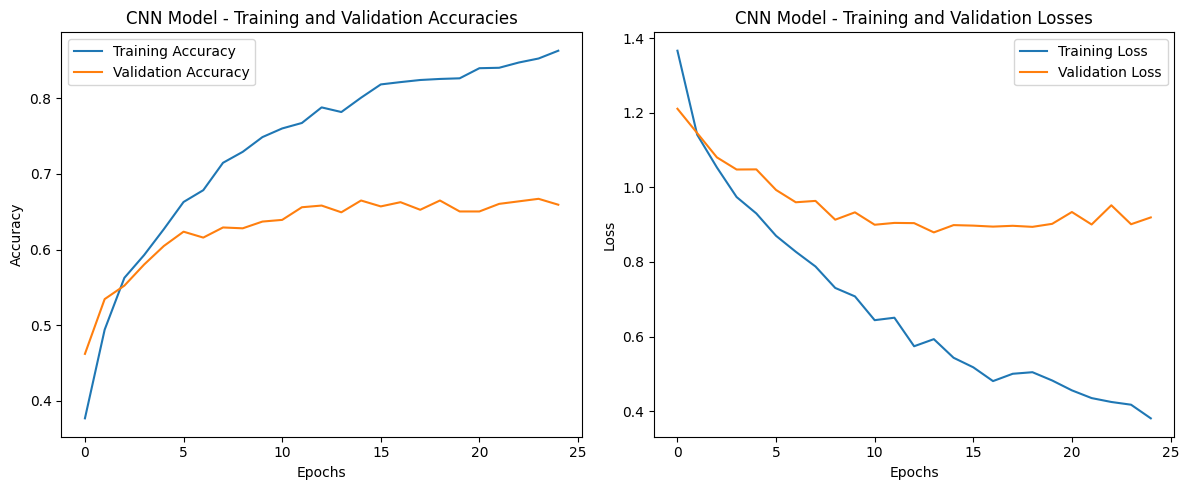

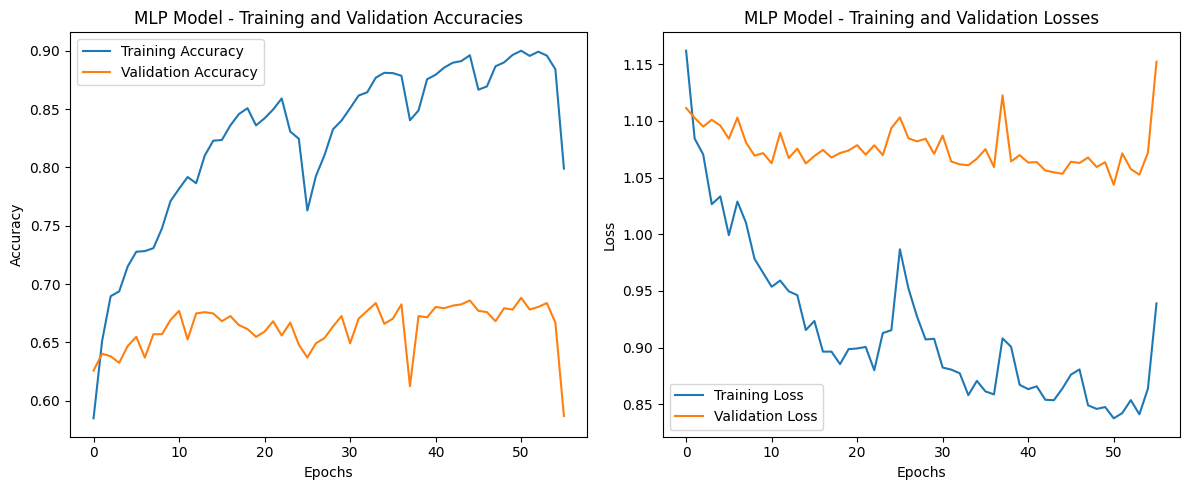

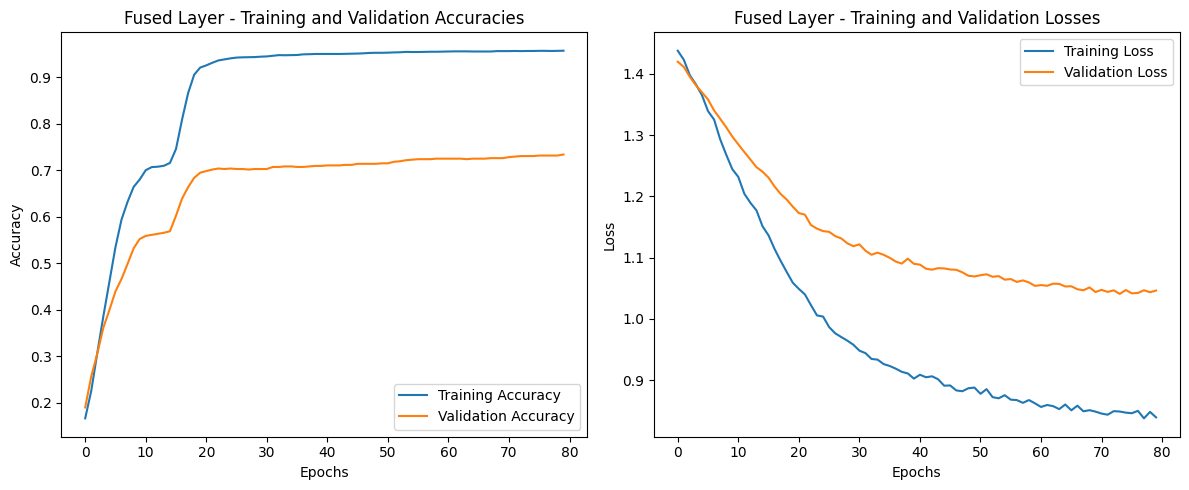

In [18]:
import matplotlib.pyplot as plt

# Plot for CNN model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_accuracy_cnn)), training_accuracy_cnn, label='Training Accuracy')
plt.plot(range(len(validation_accuracy_cnn)), validation_accuracy_cnn, label='Validation Accuracy')
plt.title('CNN Model - Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(training_losses_cnn)), training_losses_cnn, label='Training Loss')
plt.plot(range(len(validation_losses_cnn)), validation_losses_cnn, label='Validation Loss')
plt.title('CNN Model - Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot for MLP model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_accuracy_mlp)), training_accuracy_mlp, label='Training Accuracy')
plt.plot(range(len(validation_accuracy_mlp)), validation_accuracy_mlp, label='Validation Accuracy')
plt.title('MLP Model - Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(training_losses_mlp)), training_losses_mlp, label='Training Loss')
plt.plot(range(len(validation_losses_mlp)), validation_losses_mlp, label='Validation Loss')
plt.title('MLP Model - Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot for Fused Layer
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(training_accuracy_fused)), training_accuracy_fused, label='Training Accuracy')
plt.plot(range(len(validation_accuracy_fused)), validation_accuracy_fused, label='Validation Accuracy')
plt.title('Fused Layer - Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(len(training_losses_fused)), training_losses_fused, label='Training Loss')
plt.plot(range(len(validation_losses_fused)), validation_losses_fused, label='Validation Loss')
plt.title('Fused Layer - Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
